# Super-Resolution 2D DenseNet Model Architecture MRI

## 1. Libraries

In [ ]:
!nvidia-smi

Thu May 22 19:53:22 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   32C    P0             47W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
from keras.layers import Conv2D, Conv2DTranspose
from keras.layers import concatenate, Input
import matplotlib.pyplot as plt
from google.colab import drive
from keras.models import Model
import tensorflow as tf
import pandas as pd
import numpy as np
import math
import time
import os

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
tf.keras.backend.clear_session()

## 2. Managing Data

In [ ]:
path = '/content/drive/My Drive/Tesis/Data/'

In [ ]:
validation_high_mri = np.load(f'{path}validation_high_mri.npy')
validation_low_mri = np.load(f'{path}validation_low_mri_128.npy')
train_high_mri = np.load(f'{path}train_high_mri.npy')
train_low_mri = np.load(f'{path}train_low_mri_128.npy')
test_high_mri = np.load(f'{path}test_high_mri.npy')
test_low_mri = np.load(f'{path}test_low_mri_128.npy')

In [ ]:
print("Shape of validation high mri:", validation_high_mri.shape)
print("Shape of validation low mri:", validation_low_mri.shape)
print("Shape of training high mri:", train_high_mri.shape)
print("Shape of training low mri:", train_low_mri.shape)
print("Shape of test high mri:", test_high_mri.shape)
print("Shape of test low mri:", test_low_mri.shape)

Shape of validation high mri: (3147, 256, 256, 1)
Shape of validation low mri: (3147, 128, 128, 1)
Shape of training high mri: (25179, 256, 256, 1)
Shape of training low mri: (25179, 128, 128, 1)
Shape of test high mri: (3148, 256, 256, 1)
Shape of test low mri: (3148, 128, 128, 1)


## 3. Visualizing the Data

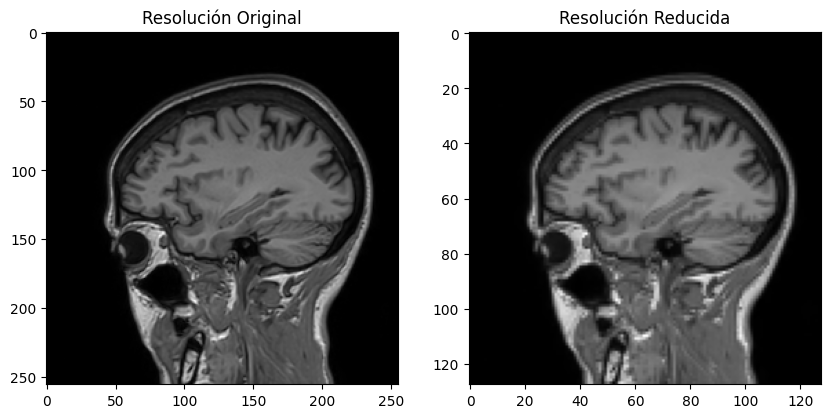

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(train_high_mri[1000], cmap='gray')
plt.title('Resolución Original')
plt.subplot(1, 2, 2)
plt.imshow(train_low_mri[1000], cmap='gray')
plt.title('Resolución Reducida')
plt.show()

## 4. Data Generator

In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, low_res_images, high_res_images, batch_size):
        self.low_res_images = low_res_images
        self.high_res_images = high_res_images
        self.batch_size = batch_size

    def __len__(self):
        return int(np.floor(len(self.low_res_images) / self.batch_size))

    def __getitem__(self, index):
        start_index = index * self.batch_size
        end_index = (index + 1) * self.batch_size
        low_res_batch = self.low_res_images[start_index:end_index]
        high_res_batch = self.high_res_images[start_index:end_index]
        return low_res_batch, high_res_batch

In [ ]:
train_generator = DataGenerator(train_low_mri, train_high_mri, batch_size=64)
validation_generator = DataGenerator(validation_low_mri, validation_high_mri, batch_size=64)

## 5. Defining the Model

SR DenseNet Model

In [ ]:
# Función para crear bloques de redes densas
def dense_net_block(inputs, i, layers):
	block = Conv2D(filters=16, kernel_size=3, padding="same", activation="relu",
								use_bias=True, name="conv2d_%d_%d" % (i + 1, 0 + 1),
					      kernel_regularizer=tf.keras.regularizers.l2(0.01))(inputs)
	for j in range(1, layers):
		middle = Conv2D(filters=16, kernel_size=3, padding="same", activation="relu",
										use_bias=True, name="conv2d_%d_%d" % (i + 1, j + 1),
						        kernel_regularizer=tf.keras.regularizers.l2(0.01))(block)
		block = concatenate([block, middle], name="concatenate_%d_%d" % (i + 1, j + 1))
	return block

# Definicion del modelo SRDenseNet
def sr_dense_net_model(blocks=8, layers=8):
	# Entrada y primera capa
	inputs = Input(shape = [128,128,1])
	logits = Conv2D(filters=16, kernel_size=3, strides=1,
					padding='same', activation="relu", use_bias=True)(inputs)
	# Genera los bloques densos
	skip = logits
	for i in range(blocks):
		logits = dense_net_block(logits, i, layers)
		logits = concatenate([logits, skip])
	# Bottleneck
	logits = Conv2D(filters=256, kernel_size=1, padding='same',
					activation="relu", use_bias=True)(logits)
	# Deconvolución
	logits = Conv2DTranspose(filters=256, kernel_size=3, strides=2,
							padding='same', activation="relu", use_bias=True)(logits)
	#logits = Conv2DTranspose(filters=1, kernel_size=3, strides=2,
	#						padding='same', activation="relu", use_bias=True)(logits)
	# Reconstrucción
	logits = Conv2D(filters=1, kernel_size=3, padding='same', use_bias=True)(logits)
	return Model(inputs, logits)

In [ ]:
model = sr_dense_net_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        160 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1_1 (Conv2D) │ (None, 128, 128,  │      2,320 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1_2 (Conv2D) │ (None, 128, 128,  │      2,320 │ conv2d_1_1[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1_2     │ (None, 128, 128,  │          0 │ conv2d_1_1[0][0], │
│ (Concatenate)       │ 32)               │            │ conv2d_1_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1_3 (Conv2D) │ (None, 128, 128,  │      4,624 │ concatenate_1_2[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1_3     │ (None, 128, 128,  │          0 │ concatenate_1_2[… │
│ (Concatenate)       │ 48)               │            │ conv2d_1_3[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1_4 (Conv2D) │ (None, 128, 128,  │      6,928 │ concatenate_1_3[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1_4     │ (None, 128, 128,  │          0 │ concatenate_1_3[… │
│ (Concatenate)       │ 64)               │            │ conv2d_1_4[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1_5 (Conv2D) │ (None, 128, 128,  │      9,232 │ concatenate_1_4[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1_5     │ (None, 128, 128,  │          0 │ concatenate_1_4[… │
│ (Concatenate)       │ 80)               │            │ conv2d_1_5[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1_6 (Conv2D) │ (None, 128, 128,  │     11,536 │ concatenate_1_5[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1_6     │ (None, 128, 128,  │          0 │ concatenate_1_5[… │
│ (Concatenate)       │ 96)               │            │ conv2d_1_6[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1_7 (Conv2D) │ (None, 128, 128,  │     13,840 │ concatenate_1_6[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1_7     │ (None, 128, 128,  │          0 │ concatenate_1_6[… │
│ (Concatenate)       │ 112)              │            │ conv2d_1_7[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1_8 (Conv2D) │ (None, 128, 128,  │     16,144 │ concatenate_1_7[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1_8     │ (None, 128, 128,  │          0 │ concatenate_1_7[

 Total params: 1,294,241 (4.94 MB)

 Trainable params: 1,294,241 (4.94 MB)

 Non-trainable params: 0 (0.00 B)

## 6. Compiling the Model

In [ ]:
# Definir la métrica SSIM
def ssim_metric(y_true, y_pred):
    y_true = tf.clip_by_value(y_true, 0, 1)
    y_pred = tf.clip_by_value(y_pred, 0, 1)
    #ssim_value = tf.map_fn(lambda x: tf.image.ssim(x[0], x[1], max_val=1.0), (y_true, y_pred), dtype=tf.float32)
    ssim_value = tf.image.ssim(y_true, y_pred, max_val=1.0)
    return tf.reduce_mean(ssim_value)

# Definir la métrica PSNR
def psnr_metric(y_true, y_pred):
    y_true = tf.clip_by_value(y_true, 0, 1)
    y_pred = tf.clip_by_value(y_pred, 0, 1)
    psnr_value = tf.image.psnr(y_true, y_pred, max_val=1.0)
    return tf.reduce_mean(psnr_value)

# SSIM como función de pérdida
def ssim_loss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5), loss='mean_absolute_error', metrics=[psnr_metric, ssim_metric])

## 7. Fitting the Model

In [ ]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="/content/drive/My Drive/Tesis/SRDenseNet/model_checkpoints/sr_densenet_trained.keras",
    save_freq="epoch",  # Guarda en cada época
    verbose=1
)

In [ ]:
start_time = time.time()
history = model.fit(train_generator, epochs=30, validation_data=validation_generator, callbacks=[checkpoint_callback])
end_time = time.time()
training_time = end_time - start_time
print(f"Tiempo de entrenamiento: {training_time:.2f} segundos")

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


393/393 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - loss: 11.6205 - psnr_metric: 47.9704 - ssim_metric: 0.9351
Epoch 1: saving model to /content/drive/My Drive/Tesis/SRDenseNet/model_checkpoints/sr_densenet_trained.keras
393/393 ━━━━━━━━━━━━━━━━━━━━ 283s 511ms/step - loss: 11.6127 - psnr_metric: 47.9777 - ssim_metric: 0.9352 - val_loss: 3.8893 - val_psnr_metric: 57.6939 - val_ssim_metric: 0.9899
Epoch 2/30
393/393 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - loss: 2.8352 - psnr_metric: 53.3682 - ssim_metric: 0.9855
Epoch 2: saving model to /content/drive/My Drive/Tesis/SRDenseNet/model_checkpoints/sr_densenet_trained.keras
393/393 ━━━━━━━━━━━━━━━━━━━━ 192s 489ms/step - loss: 2.8332 - psnr_metric: 53.3700 - ssim_metric: 0.9855 - val_loss: 0.8876 - val_psnr_metric: 59.0298 - val_ssim_metric: 0.9928
Epoch 3/30
393/393 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - loss: 0.6400 - psnr_metric: 55.1424 - ssim_metric: 0.9904
Epoch 3: saving model to /content/drive/My Drive/Tesis/SRDenseNet/model_checkpoints/sr_densen

In [ ]:
model.save("/content/drive/My Drive/Tesis/SRDenseNet/sr_2d_densenet_mri_trained.keras")

## 8. Evaluating the Model

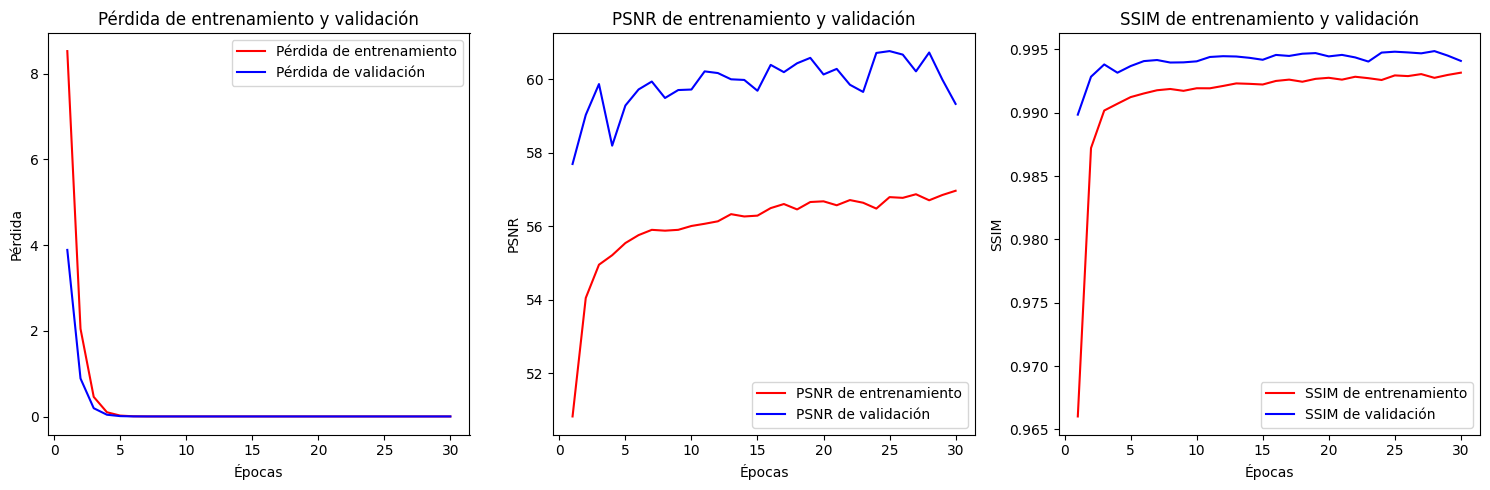

In [ ]:
# Obtener las métricas del historial de entrenamiento
loss = history.history['loss']
val_loss = history.history['val_loss']
psnr = history.history['psnr_metric']
val_psnr = history.history['val_psnr_metric']
ssim = history.history['ssim_metric']
val_ssim = history.history['val_ssim_metric']

np.save('/content/drive/My Drive/Tesis/SRDenseNet/loss.npy', loss)
np.save('/content/drive/My Drive/Tesis/SRDenseNet/val_loss.npy', val_loss)
np.save('/content/drive/My Drive/Tesis/SRDenseNet/psnr.npy', psnr)
np.save('/content/drive/My Drive/Tesis/SRDenseNet/val_psnr.npy', val_psnr)
np.save('/content/drive/My Drive/Tesis/SRDenseNet/ssim.npy', ssim)
np.save('/content/drive/My Drive/Tesis/SRDenseNet/val_ssim.npy', val_ssim)

epochs = range(1, len(loss) + 1)

# Crear una figura con 3 subgráficas en una fila
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Graficar la pérdida
axs[0].plot(epochs, loss, 'r', label='Pérdida de entrenamiento')
axs[0].plot(epochs, val_loss, 'b', label='Pérdida de validación')
axs[0].set_title('Pérdida de entrenamiento y validación')
axs[0].set_xlabel('Épocas')
axs[0].set_ylabel('Pérdida')
axs[0].legend()

# Graficar el PSNR
axs[1].plot(epochs, psnr, 'r', label='PSNR de entrenamiento')
axs[1].plot(epochs, val_psnr, 'b', label='PSNR de validación')
axs[1].set_title('PSNR de entrenamiento y validación')
axs[1].set_xlabel('Épocas')
axs[1].set_ylabel('PSNR')
axs[1].legend()

# Graficar el SSIM
axs[2].plot(epochs, ssim, 'r', label='SSIM de entrenamiento')
axs[2].plot(epochs, val_ssim, 'b', label='SSIM de validación')
axs[2].set_title('SSIM de entrenamiento y validación')
axs[2].set_xlabel('Épocas')
axs[2].set_ylabel('SSIM')
axs[2].legend()

# Ajustar el layout
plt.tight_layout()
plt.savefig('/content/drive/My Drive/Tesis/SRDenseNet/train_densenet.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Evaluación en el conjunto de validación
loss, psnr_value, ssim_value = model.evaluate(validation_low_mri, validation_high_mri)
print(f"Loss: {loss}")
print(f"PSNR: {psnr_value}")
print(f"SSIM: {ssim_value}")

99/99 ━━━━━━━━━━━━━━━━━━━━ 26s 144ms/step - loss: 0.0011 - psnr_metric: 60.7166 - ssim_metric: 0.9946
Loss: 0.001207647961564362
PSNR: 59.41823196411133
SSIM: 0.9941490292549133


## 9. Making Predictions

In [ ]:

def mse_metric(target, ref):
    mse_value = tf.square(target - ref)
    return tf.reduce_mean(mse_value)

def compare_images(real, pred):
    scores = []
    scores.append(i)
    scores.append(psnr_metric(real, pred).numpy())
    scores.append(ssim_metric(real, pred).numpy())
    scores.append(mse_metric(real, pred).numpy())
    print(scores)
    return scores

In [ ]:
def plot_images(high,low,predicted,i):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('High MRI', color='black', fontsize=20)
    plt.imshow(high, cmap='gray')
    plt.subplot(1,3,2)
    plt.title('Low MRI', color='black', fontsize=20)
    plt.imshow(low, cmap='gray')
    plt.subplot(1,3,3)
    plt.title('Predicted MRI', color='black', fontsize=20)
    plt.imshow(predicted, cmap='gray')
    plt.savefig(f'/content/drive/My Drive/Tesis/SRDenseNet/result_densenet_{i}.png', dpi=300, bbox_inches='tight')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
[220, np.float32(42.310146), np.float32(0.9738885), np.float32(5.8756443e-05)]


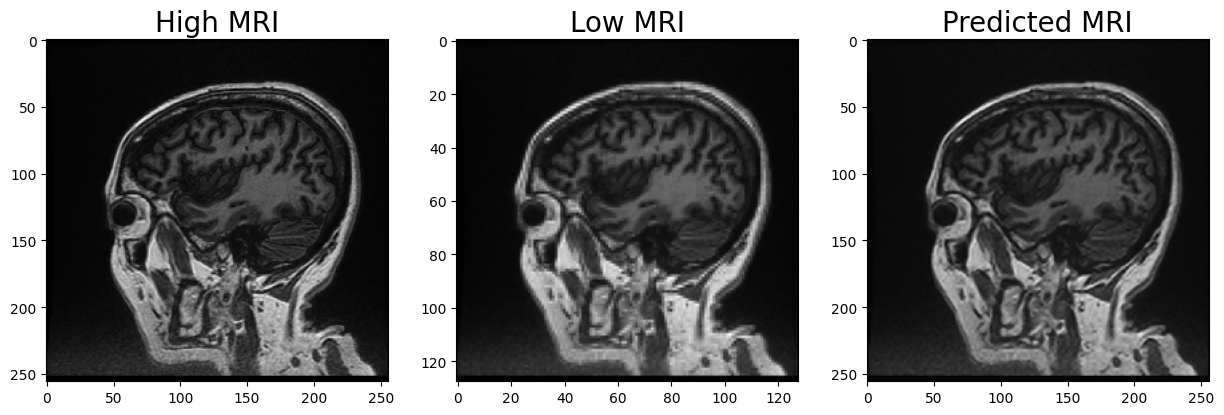

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
[230, np.float32(42.161697), np.float32(0.9715563), np.float32(6.0796297e-05)]


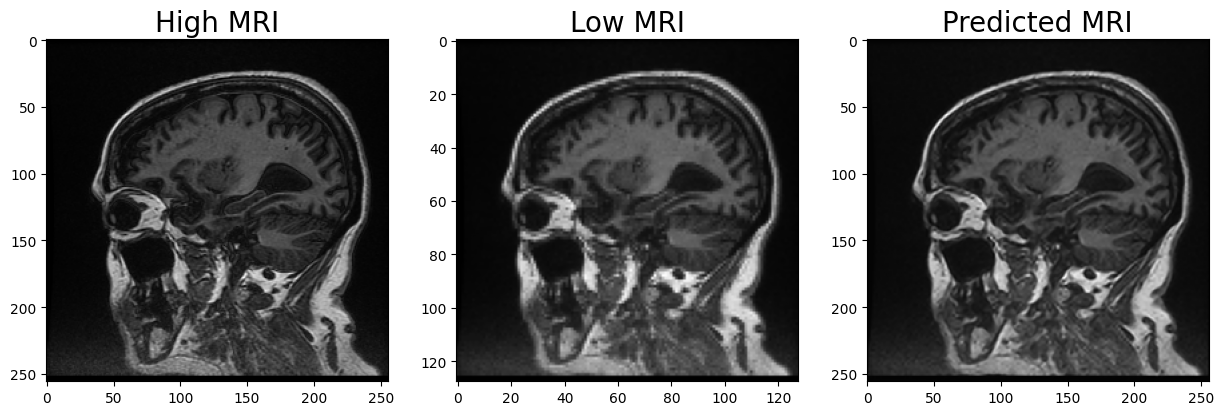

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
[240, np.float32(42.25867), np.float32(0.9717187), np.float32(5.9454396e-05)]


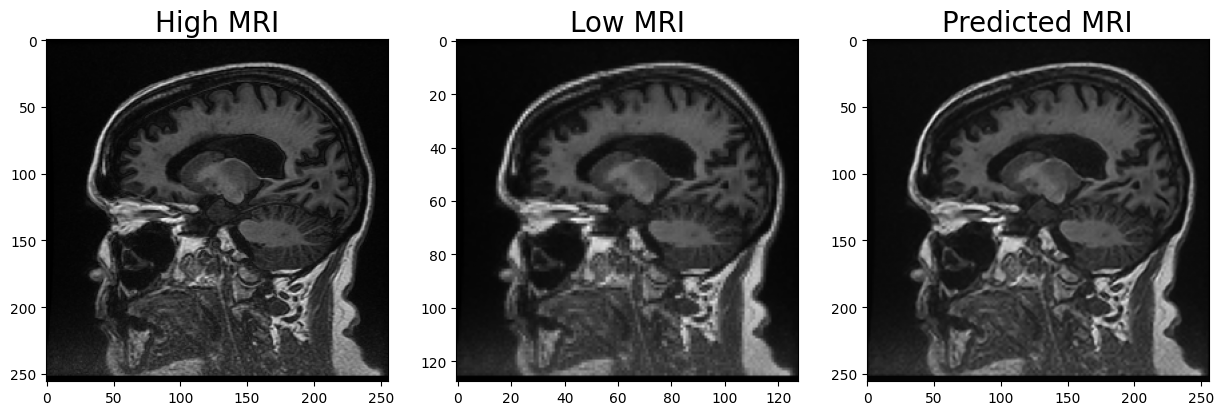

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
[250, np.float32(43.09844), np.float32(0.97267014), np.float32(4.900193e-05)]


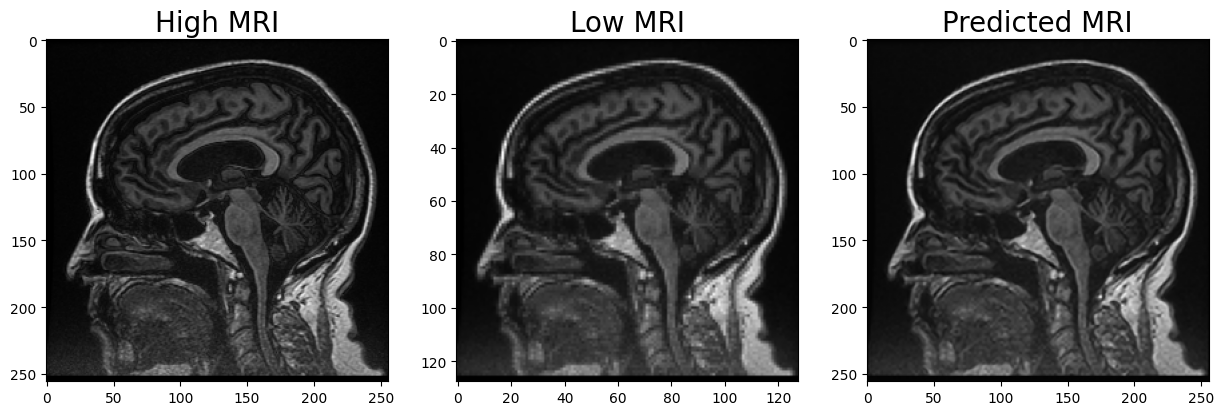

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
[260, np.float32(43.01641), np.float32(0.9728506), np.float32(4.993616e-05)]


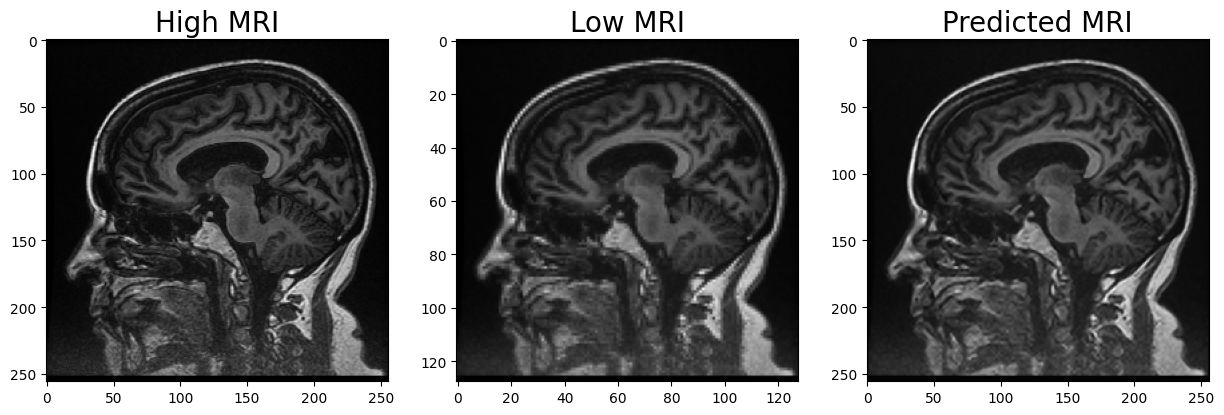

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
[270, np.float32(42.48143), np.float32(0.9738672), np.float32(5.648034e-05)]


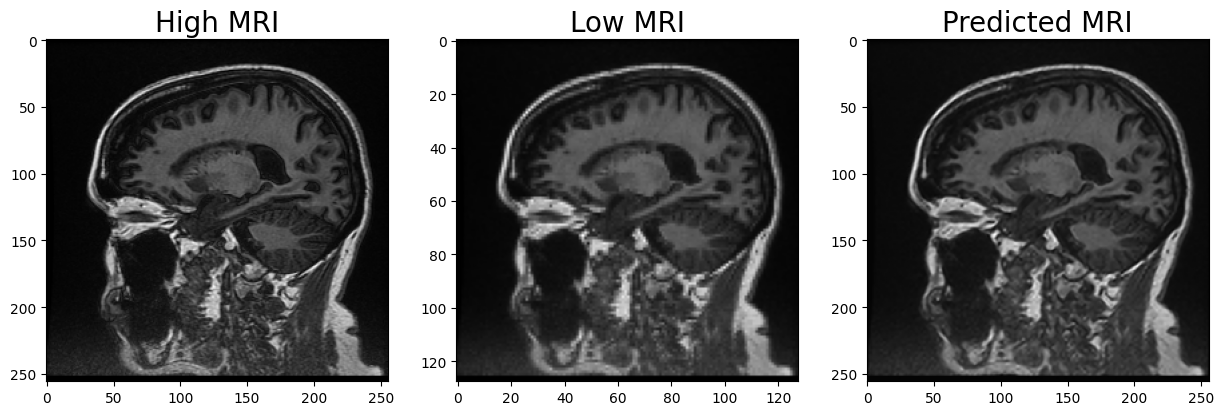

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
[280, np.float32(42.54185), np.float32(0.97511315), np.float32(5.5699194e-05)]


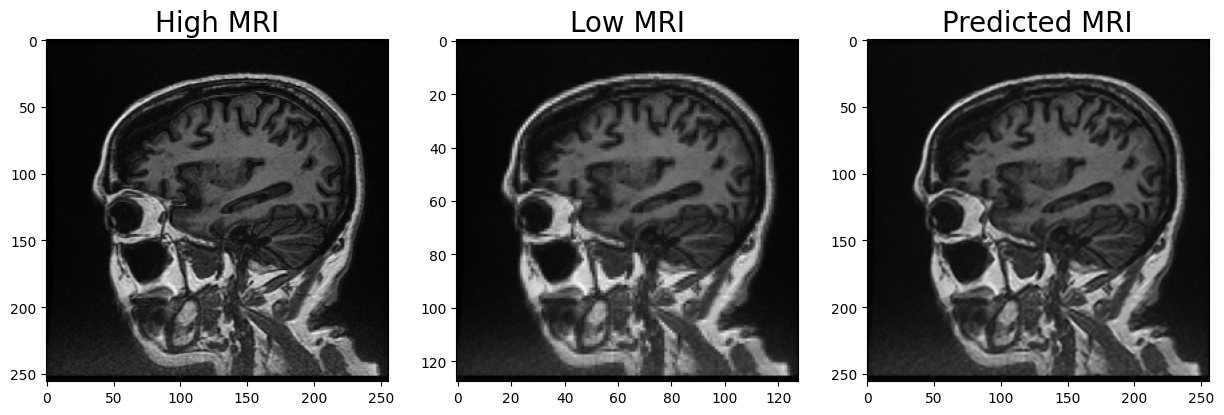

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
[290, np.float32(43.490986), np.float32(0.97876495), np.float32(4.4766643e-05)]


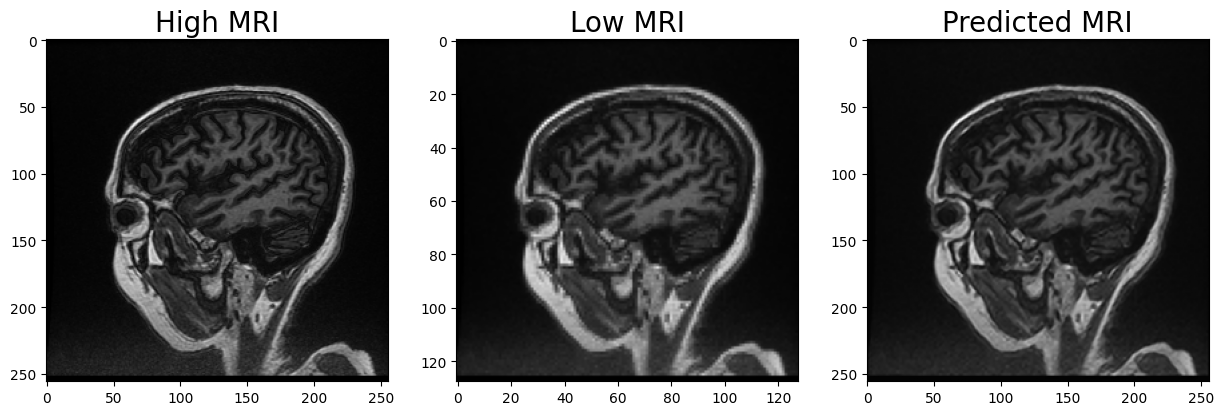

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
[300, np.float32(45.017647), np.float32(0.983761), np.float32(3.1496682e-05)]


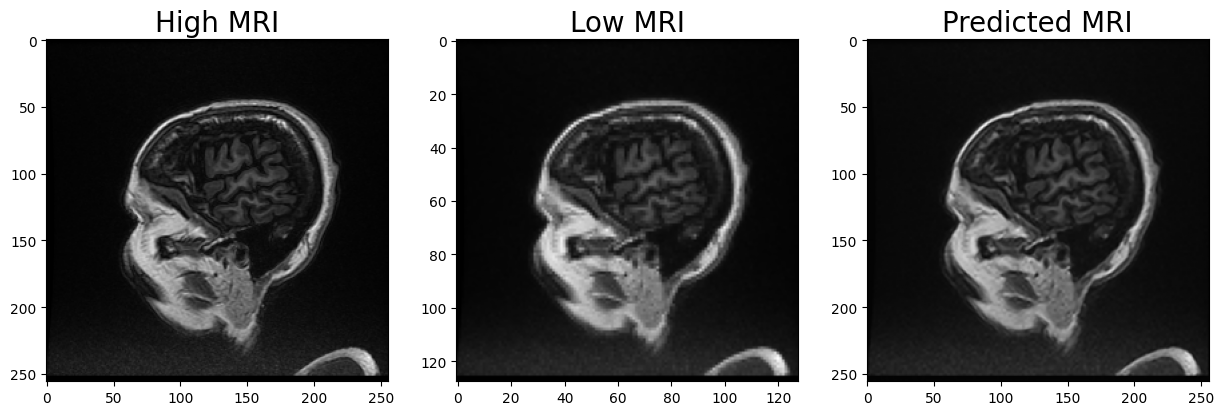

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
[310, np.float32(48.155987), np.float32(0.9905242), np.float32(1.5291596e-05)]


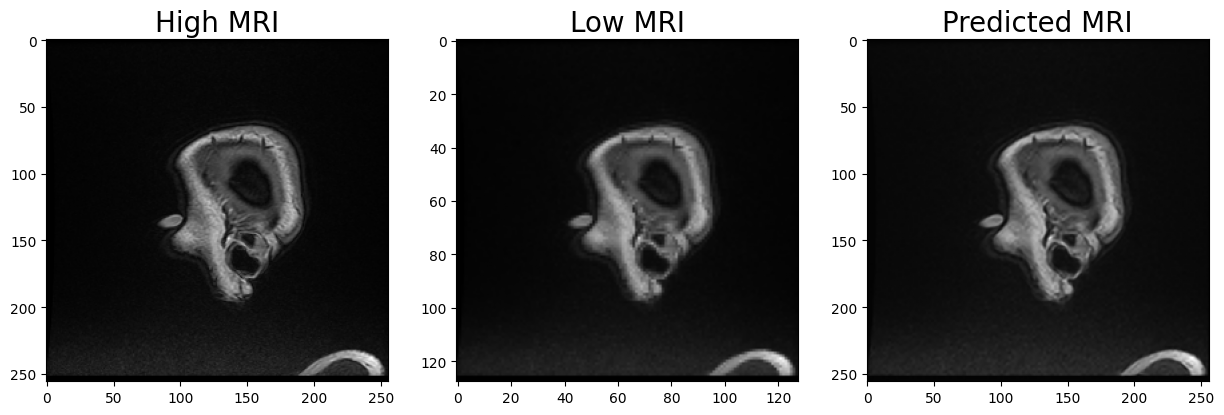

In [ ]:
scores = []
for i in [220,230,240,250,260,270,280,290,300,310]:
    predicted = model.predict(test_low_mri[i].reshape(1,128,128,1))
    scores.append(compare_images(test_high_mri[i], predicted))
    plot_images(test_high_mri[i],test_low_mri[i],predicted[0],i)

In [ ]:
df_scores = pd.DataFrame(scores)
df_scores.columns = ['Item','PSNR','SSIM','MSE']
df_scores

Item       PSNR      SSIM       MSE
0   220  42.310146  0.973889  0.000059
1   230  42.161697  0.971556  0.000061
2   240  42.258671  0.971719  0.000059
3   250  43.098438  0.972670  0.000049
4   260  43.016411  0.972851  0.000050
5   270  42.481430  0.973867  0.000056
6   280  42.541851  0.975113  0.000056
7   290  43.490986  0.978765  0.000045
8   300  45.017647  0.983761  0.000031
9   310  48.155987  0.990524  0.000015